In [1]:
# Import necessary libraries
import os
import sys
import hist
import uproot
import statistics
import numpy as np
import pandas as pd
import awkward as ak
import mplhep as hep
from hist import Hist
import matplotlib as mpl
import matplotlib.pyplot as plt
# Set matplotlib styling parameters
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['grid.color'] = "#CCCCCC"
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['figure.edgecolor'] = 'none'

In [2]:
# Function to read a specific branch in a root file individually for memory efficiency
def read_file(input_dir, file_name): 
    # Open the root file
    file = uproot.open(f"{input_dir}/{file_name}")
    
    # Access the 'LDMX_Events' tree in the root file
    ldmx_events = file['LDMX_Events']
    
    # Define the process name for filtering
    procName = "electron"
    
    # Create a dictionary of events using awkward arrays
    events = ak.zip({
        "PFEcalClusters": ak.zip({
            "id": ldmx_events[f"PFEcalClusters_{procName}.energy_"].array(library='ak'),
            "centroidX": ldmx_events[f"PFEcalClusters_{procName}.centroidX_"].array(library='ak'),
            "centroidY": ldmx_events[f"PFEcalClusters_{procName}.centroidY_"].array(library='ak'),
            "centroidZ": ldmx_events[f"PFEcalClusters_{procName}.centroidZ_"].array(library='ak'),
        }),
    }, depth_limit=1)    # Limit the depth for memory efficiency
    return events

In [3]:
# Function to read a specific branch in a root file individually for memory efficiency
def readx_file(input_dir, file_name):
    # Open the root file
    file = uproot.open(f"{input_dir}/{file_name}")

    # Access the 'LDMX_Events' tree in the root file
    ldmx_events = file['LDMX_Events']

    # Define the process name for filtering
    procName = "electron"
    
    # Create a dictionary of events using awkward arrays
    events = ak.zip({
       
        "trigScintDigisPad3":ak.zip({
            "id"    : ldmx_events[f"trigScintDigisPad3_{procName}.id_"].array(library='ak'),
            "x"    : ldmx_events[f"trigScintDigisPad3_{procName}.xpos_"].array(library='ak'),
            "y"    : ldmx_events[f"trigScintDigisPad3_{procName}.ypos_"].array(library='ak'),

        }),
    }, depth_limit=1)    # Limit the depth for memory efficiency
    return events

In [4]:
# Function to define the electron of interest for analysis based on a selection criteria
def clust_electron_selection(arr):
    # Use ak.argmax to find the index of the maximum 'id' for each sub-array
    max_id_indices = ak.argmax(arr.id, axis=1)
    
    # Create a mask based on the indices of the maximum 'id' for each sub-array
    mask = ak.Array([[i == max_id for i in range(len(sub_array))] for max_id, sub_array in zip(max_id_indices, arr)])
    
    return mask

In [5]:
# Function to select electrons of interest based on a predefined criteria
def get_select_values(events):
    # Use the previously defined function to obtain a mask for electron selection
    PFEClust_electron_selection = clust_electron_selection(events["PFEcalClusters"]) 
    
    # Apply the mask to get selected electron values
    PFEClust_electrons = events["PFEcalClusters"][PFEClust_electron_selection]
    
    return PFEClust_electrons

In [6]:
# Function to flatten the input array and fill empty values with -99999
def to_flat(arr):
    return ak.fill_none(ak.pad_none(ak.firsts(arr), 1, axis=0), value=-99999, axis=0).to_numpy()

In [7]:
# Function uses stored weights (predictions of momentum) for the reconstruction of the x momentum
def get_x_weight(x_value, ex_value):
    tmp = 0  # Index to return
    tmp2 = 0

    # Check if x_value and ex_value are not None
    if x_value is not None and ex_value is not None:
        # Out of bound index condition
        condition = (x_value < -100) | (x_value > 100) | (ex_value < 0) | (ex_value > 8000)

        if np.any(condition):
            return -99999  # Default x value for out-of-bound

        # Loop through dx bins and compare each index to the x value passed
        for i in range(len(dx_bins)):
            if x_value > dx_bins[i]:
                tmp = i
            else:
                break

        # Loop through energy bins and compare each index to the x value passed
        for j in range(len(ex_bins)):
            if ex_value > ex_bins[j]:
                tmp2 = j
            else:
                break

    # Keep tmp and tmp2 within the index of px weights array
    tmp = min(tmp, len(px_weights) - 1)
    tmp2 = min(tmp2, len(px_weights[0]) - 1)

    # Return the x value based on the x value of temp(s)
    return px_weights[tmp][tmp2]

In [8]:
# Function uses stored weights (predictions of momentum) for the reconstruction of the Y momentum
def get_y_weight(y_value, ey_value):
    tmp = 0  # Index to return
    tmp2 = 0

    # Check if y_value and ey_value are not None
    if y_value is not None and ey_value is not None:
        # Out of bound index condition
        condition = (y_value < -100) | (y_value > 100) | (ey_value < 0) | (ey_value > 8000)

        if np.any(condition):
            return -99999  # Default value for out-of-bound

        # Loop through dy bins and compare each index to the y value passed
        for i in range(len(dy_bins)):
            if y_value > dy_bins[i]:
                tmp = i
            else:
                break

        # Loop through energy bins and compare each index to the y value passed
        for j in range(len(ey_bins)):
            if ey_value > ey_bins[j]:
                tmp2 = j
            else:
                break

    # Keep tmp and tmp2 within the index of py weights array
    tmp = min(tmp, len(py_weights) - 1)
    tmp2 = min(tmp2, len(py_weights[0]) - 1)

    # Return the y value based on the value of temp(s)
    return py_weights[tmp][tmp2]

In [9]:
# Directory path to the root files
input_dir = "/Users/deep/Downloads/cernBox2/"
PFEClust_electrons = []  # List to store selected PFEcalClusters electrons
trigscint_electrons = []  # List to store selected trigScintDigisPad3 electrons

# Loop through the range of files
for i in range(151):
    file_name = f"{i}_egps_upstreamtagger_8_1_gev.root"
    file_path = os.path.join(input_dir, file_name)

    # Check if the file exists
    if os.path.exists(file_path):
        # Read PFEcalClusters and trigScintDigisPad3 events from the root file
        events = read_file(input_dir, file_name)
        scint_events = readx_file(input_dir, file_name)

        # Select PFEcalClusters electrons based on predefined criteria
        PFEClust_electrons.append(get_select_values(events))

        # Store trigScintDigisPad3 events
        trigscint_electrons.append(scint_events)
    else:
        print(f" The file {file_name} DNE")

 The file 45_egps_upstreamtagger_8_1_gev.root DNE
 The file 111_egps_upstreamtagger_8_1_gev.root DNE
 The file 131_egps_upstreamtagger_8_1_gev.root DNE
 The file 132_egps_upstreamtagger_8_1_gev.root DNE
 The file 133_egps_upstreamtagger_8_1_gev.root DNE
 The file 134_egps_upstreamtagger_8_1_gev.root DNE
 The file 135_egps_upstreamtagger_8_1_gev.root DNE
 The file 136_egps_upstreamtagger_8_1_gev.root DNE
 The file 137_egps_upstreamtagger_8_1_gev.root DNE
 The file 138_egps_upstreamtagger_8_1_gev.root DNE
 The file 139_egps_upstreamtagger_8_1_gev.root DNE
 The file 140_egps_upstreamtagger_8_1_gev.root DNE
 The file 141_egps_upstreamtagger_8_1_gev.root DNE
 The file 142_egps_upstreamtagger_8_1_gev.root DNE


In [10]:
# Load x momentum weights from the file
with open('px_weights.npy', 'rb') as f:
    px_weights = np.load(f)

# Load y momentum weights from the file
with open('py_weights.npy', 'rb') as f:
    py_weights = np.load(f)

# Load bins for dx (Ecal scoring - target scoring) from the file
with open('dx_bins.npy', 'rb') as f:
    dx_bins = np.load(f)

# Load bins for ex (Ecal scoring - target scoring) from the file
with open('ex_bins.npy', 'rb') as f:
    ex_bins = np.load(f)

# Load bins for dy from the file
with open('dy_bins.npy', 'rb') as f:
    dy_bins = np.load(f)

# Load bins for ey from the file
with open('ey_bins.npy', 'rb') as f:
    ey_bins = np.load(f)

In [45]:
print(px_weights)
print("blah")
print(dx_bins)

[[ -158.29315491  -429.98490984  -671.22171154     0.
      0.             0.             0.             0.
      0.             0.        ]
 [ -158.78285     -438.3840119   -682.19734015  -936.75516776
  -1195.97246149 -1462.6388125  -1721.88229611 -1981.93869918
  -2235.06005047 -2417.58019397]
 [ -153.3226958   -392.3457993   -611.96602957  -850.88861346
  -1084.95731794 -1319.05562792 -1554.15830651 -1798.15482412
  -2032.64452778 -2258.81831912]
 [ -139.34500993  -345.13183045  -540.30707106  -745.79380596
   -956.71445873 -1162.7210352  -1363.7187349  -1571.15423694
  -1776.498006   -1979.71712325]
 [ -122.50083989  -298.5868101   -462.75794801  -640.50434734
   -815.27392399  -993.3787931  -1165.2066771  -1344.00545201
  -1514.46227676 -1696.15390429]
 [ -109.44710255  -251.30034133  -383.10755821  -530.89212672
   -675.34542277  -822.8511595   -967.81444638 -1108.99230626
  -1252.86580347 -1398.40591157]
 [  -83.64652614  -201.05625429  -304.99831889  -418.2343516
   -532.76522

In [11]:
# Lists to store flattened PFEcalClusters electron centroidX, centroidY, and id values
PFEClust_x = []
PFEClust_y = []
PFEClust_E = []

# Loop through the selected PFEcalClusters electrons
for i in range(len(PFEClust_electrons)):
    # Append flattened centroidX, centroidY, and id values to the respective lists
    PFEClust_x.append(to_flat(PFEClust_electrons[i].centroidX))
    PFEClust_y.append(to_flat(PFEClust_electrons[i].centroidY))
    PFEClust_E.append(to_flat(PFEClust_electrons[i].id))

# Flatten the lists to obtain 1D arrays
PFEClust_x = ak.ravel(PFEClust_x)
PFEClust_y = ak.ravel(PFEClust_y)
PFEClust_E = ak.ravel(PFEClust_E)

In [12]:
# Create a list containing 'trigScintDigisPad3' field from each array in trigscint_electrons
trigScintDigisPad3_list = [array['trigScintDigisPad3'] for array in trigscint_electrons]

# Flatten the structure to obtain a flat array of dictionaries
flat_trigScintDigisPad3 = ak.flatten(trigScintDigisPad3_list)

# Access the 'x' and 'y' fields for each dictionary in the flat array
all_x_values = flat_trigScintDigisPad3['x']
all_y_values = flat_trigScintDigisPad3['y']

# Extract the first 'x' and 'y' values from the arrays
trigscint_x_values = ak.firsts(all_x_values)
trigscint_y_values = ak.firsts(all_y_values)

In [13]:
# Calculate the differences between PFEcalClusters and trigScintDigisPad3 'x' and 'y' values
clust_dx = PFEClust_x - trigscint_x_values
clust_dy = PFEClust_y - trigscint_y_values

# Lists to store reconstructed cluster px and py values
recon_clust_px = []
recon_clust_py = []

# Loop through the range of PFEcalClusters electron energies
for i in range(len(PFEClust_E)):
    # Calculate the x and y weights for the reconstruction
    tmp = get_x_weight(clust_dx[i], PFEClust_E[i])
    tmp2 = get_y_weight(clust_dy[i], PFEClust_E[i])
    
    # Append the reconstructed px and py values to the respective lists
    recon_clust_py.append(tmp2)
    recon_clust_px.append(tmp)

# Calculate the hypotenuse of reconstructed px and py to get reconstructed pt
recon_clust_pt = np.hypot(recon_clust_px, recon_clust_py)

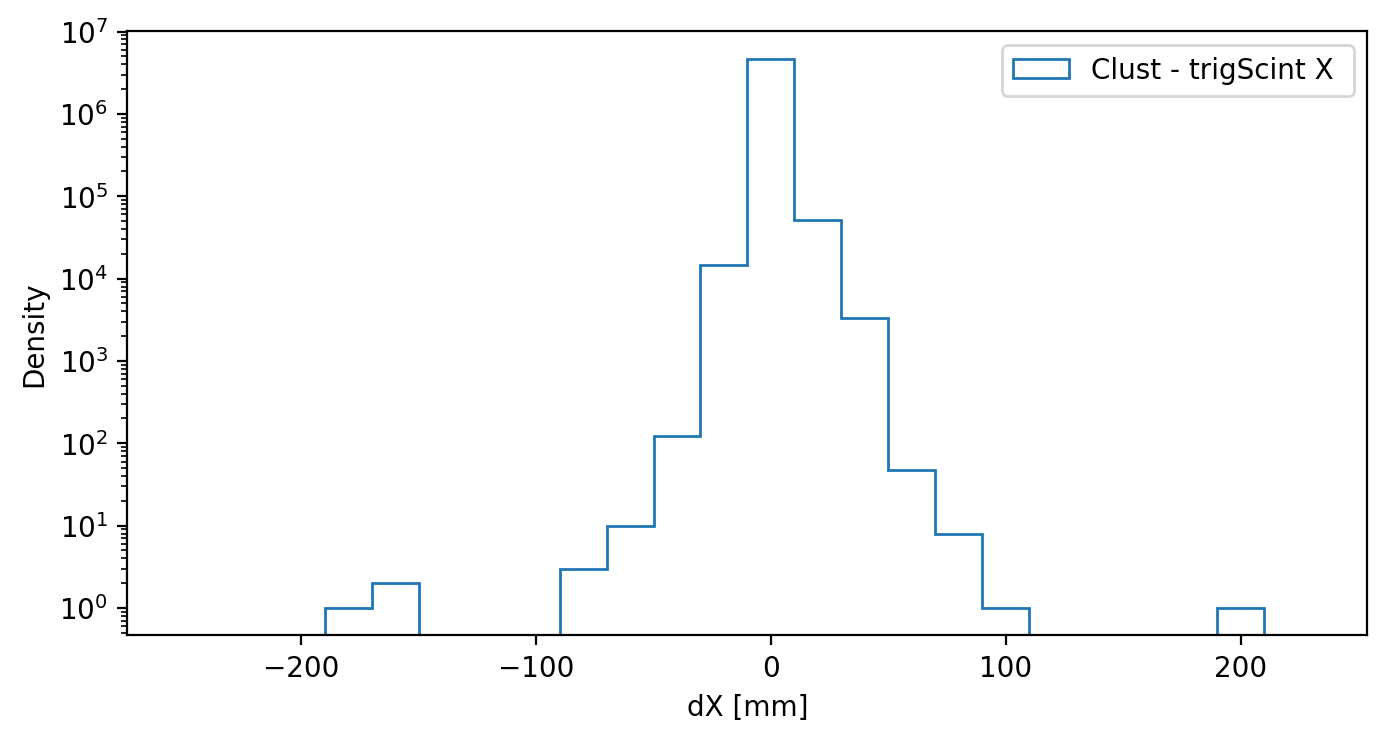

In [49]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

# Plot the histogram of reconstructed px values
ax.hist(clust_dx, label='Clust - trigScint X ', bins=np.arange(-250, 250, 20), histtype='step')

# Set labels and scale for the plot
ax.set_xlabel('dX [mm]')
ax.set_ylabel('Density')
ax.set_yscale('log')

# Add legend to the upper right corner
ax.legend(loc='upper right')

# Show the plot
plt.show()

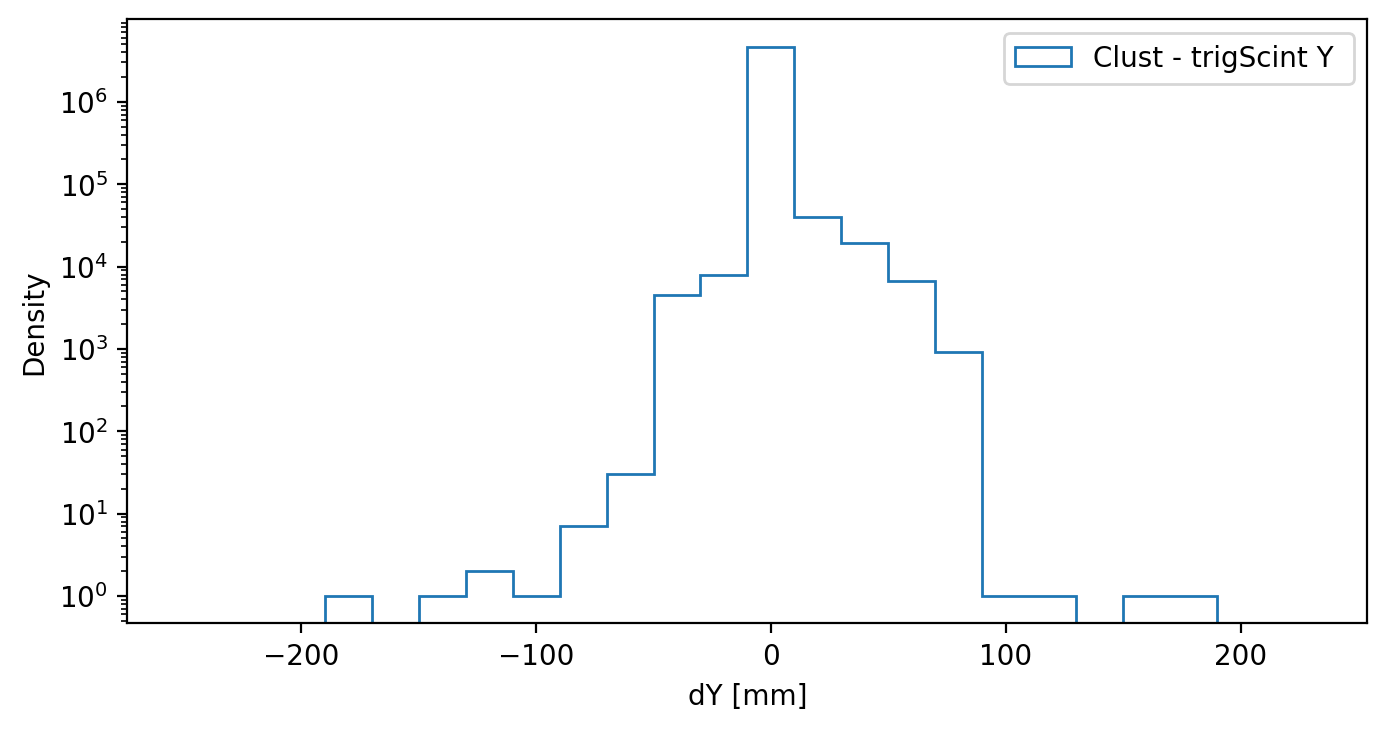

In [51]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

# Plot the histogram of reconstructed px values
ax.hist(clust_dy, label='Clust - trigScint Y ', bins=np.arange(-250, 250, 20), histtype='step')

# Set labels and scale for the plot
ax.set_xlabel('dY [mm]')
ax.set_ylabel('Density')
ax.set_yscale('log')

# Add legend to the upper right corner
ax.legend(loc='upper right')

# Show the plot
plt.show()

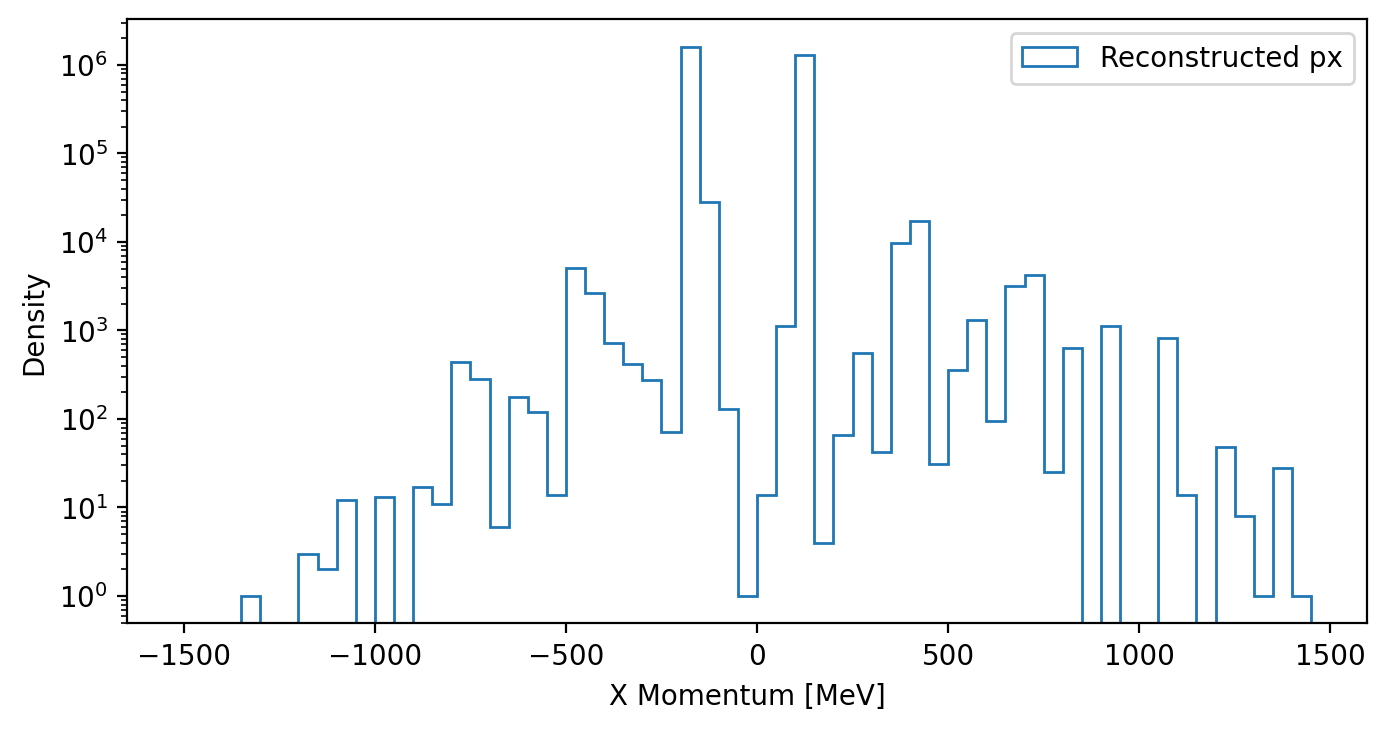

In [40]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

# Plot the histogram of reconstructed px values
ax.hist(recon_clust_px, label='Reconstructed px', bins=np.arange(-1500, 1500, 50), histtype='step')

# Set labels and scale for the plot
ax.set_xlabel('X Momentum [MeV]')
ax.set_ylabel('Density')
ax.set_yscale('log')

# Add legend to the upper right corner
ax.legend(loc='upper right')

# Show the plot
plt.show()

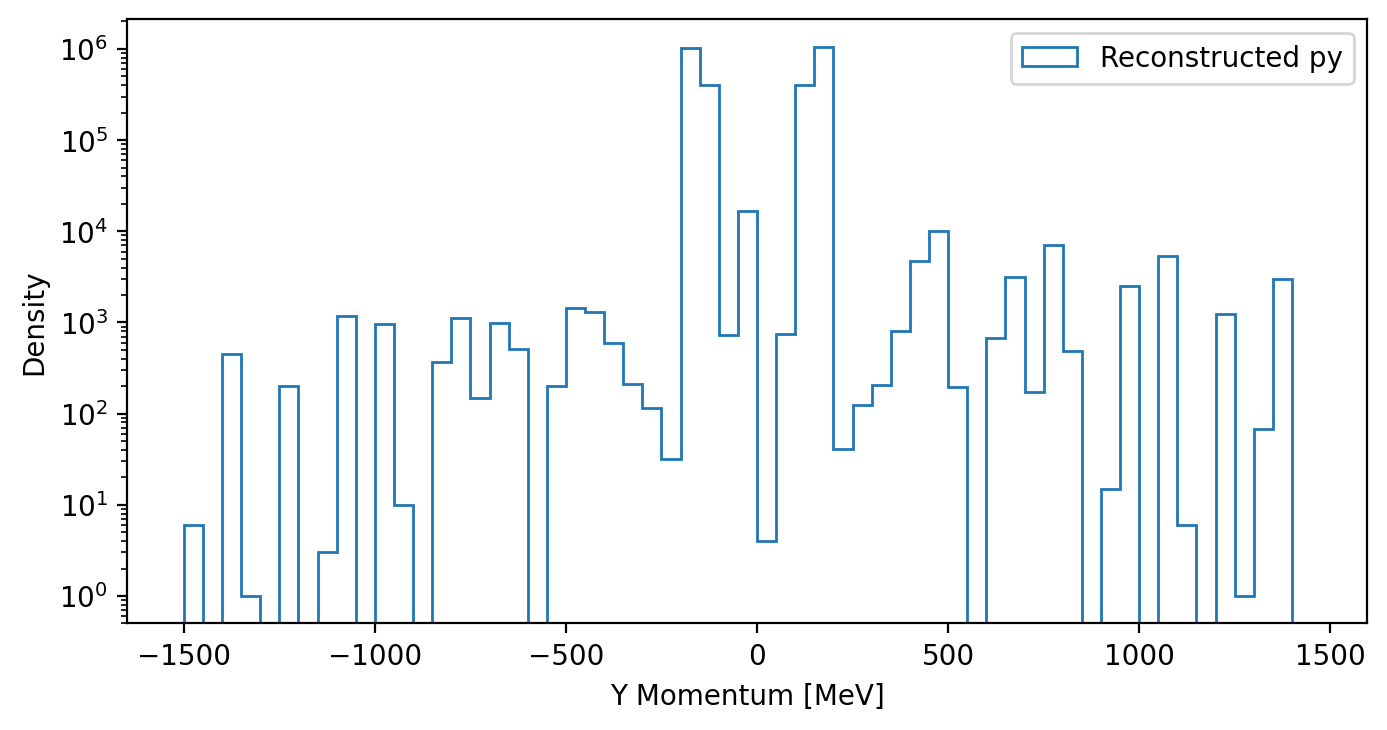

In [39]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

# Plot the histogram of reconstructed py values
ax.hist(recon_clust_py, label='Reconstructed py', bins=np.arange(-1500, 1500, 50), histtype='step')

# Set labels and scale for the plot
ax.set_xlabel('Y Momentum [MeV]')
ax.set_ylabel('Density')
ax.set_yscale('log')

# Add legend to the upper right corner
ax.legend(loc='upper right')

# Show the plot
plt.show()

In [38]:
print (len(recon_clust_pt))
print (len(recon_clust_px))
print (len(recon_clust_py))

4734997
4734997
4734997


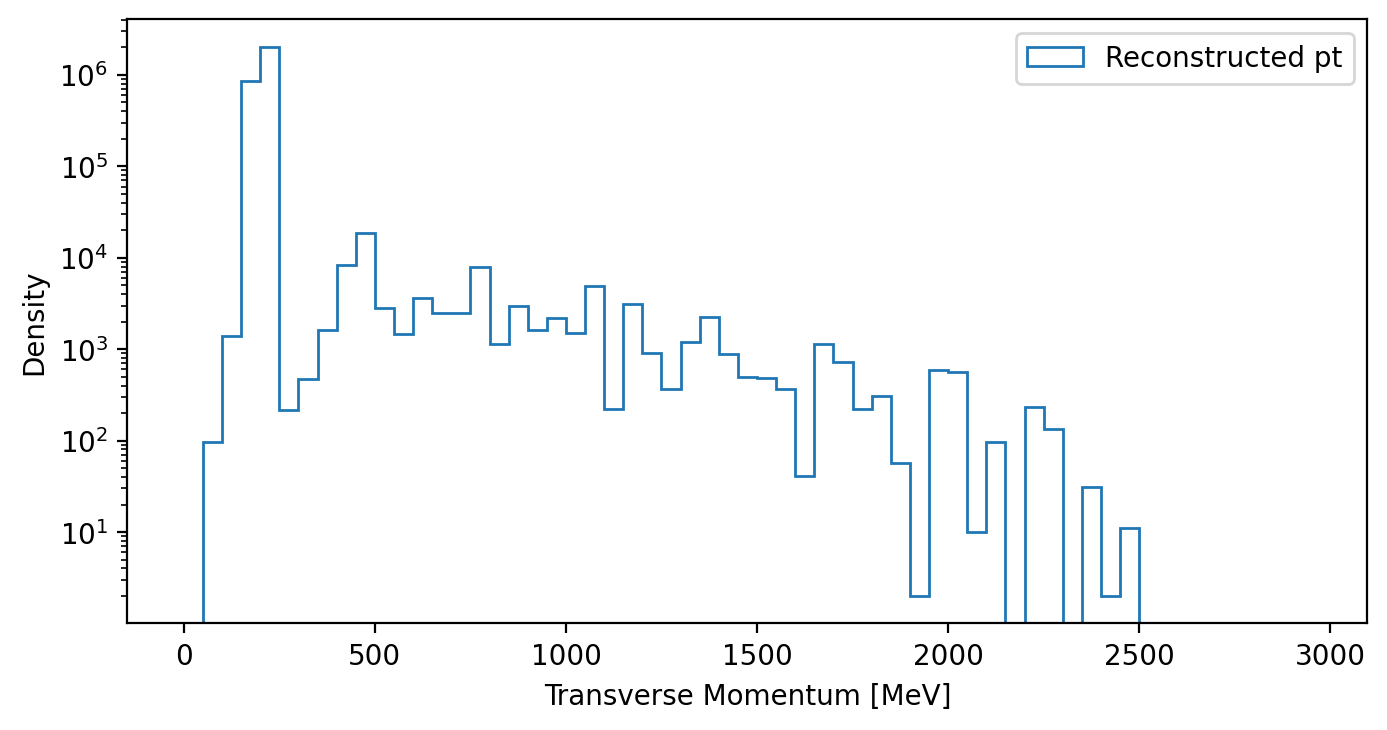

In [36]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

# Plot the histogram of reconstructed pt values
ax.hist(recon_clust_pt, label='Reconstructed pt', bins=np.arange(0, 3000, 50), histtype='step')

# Set labels and scale for the plot
ax.set_xlabel('Transverse Momentum [MeV]')
ax.set_ylabel('Density')
ax.set_yscale('log')

# Add legend to the upper right corner
ax.legend(loc='upper right')

# Show the plot
plt.show()

In [17]:
# Define histogram bins for the transverse momentum (pt) histogram
hist_bins = np.arange(0, 3000, 30)

# Create a histogram object with specified bins
pt_h = hist.Hist(
    hist.axis.Regular(20, 0, 3000, name="pT_histogram", label="pT [MeV]"),
)

# Fill the histogram with reconstructed transverse momentum (pt) values
pt_h.fill(pT_histogram=recon_clust_pt)

# Sum the values in the histogram
pt_h_sum = sum(pt_h.project("pT_histogram").to_numpy()[0])

In [18]:
# Initialize an empty list to store sums for different pt ranges
all_ranges = []

# Loop through histogram bins and calculate sums for each range
for i in range(len(hist_bins)):
    # Create a mask for values greater than the current bin
    mask = recon_clust_pt > (hist_bins[i])
    # Apply the mask to get values within the current range
    mask_cut = recon_clust_pt[mask]

    # Create a histogram object for the current range
    pt_h_cut = hist.Hist(
        hist.axis.Regular(20, hist_bins[i], 3000, name="pT_hist", label="pT [MeV]"),
    )
    # Fill the histogram with values within the current range
    pt_h_cut.fill(pT_hist=mask_cut)

    # Append the sum of values in the current range to the list
    all_ranges.append(sum(pt_h_cut.project("pT_hist").to_numpy()[0]))

In [19]:
# Initialize an empty list to store normalized values for each pt range
range_cut = []

# Loop through all_ranges and calculate the normalized values
for i in range(len(all_ranges)):
    # Calculate the normalized value by dividing the sum in the range by the total sum
    range_cut.append(all_ranges[i] / pt_h_sum)

In [20]:
# range cut = allranges/total = signal efficiency
#all ranges = # of counts after cut = rate


In [21]:
# all_ranges.append(0)

In [22]:
print(len(all_ranges))
print(len(range_cut))

100
100


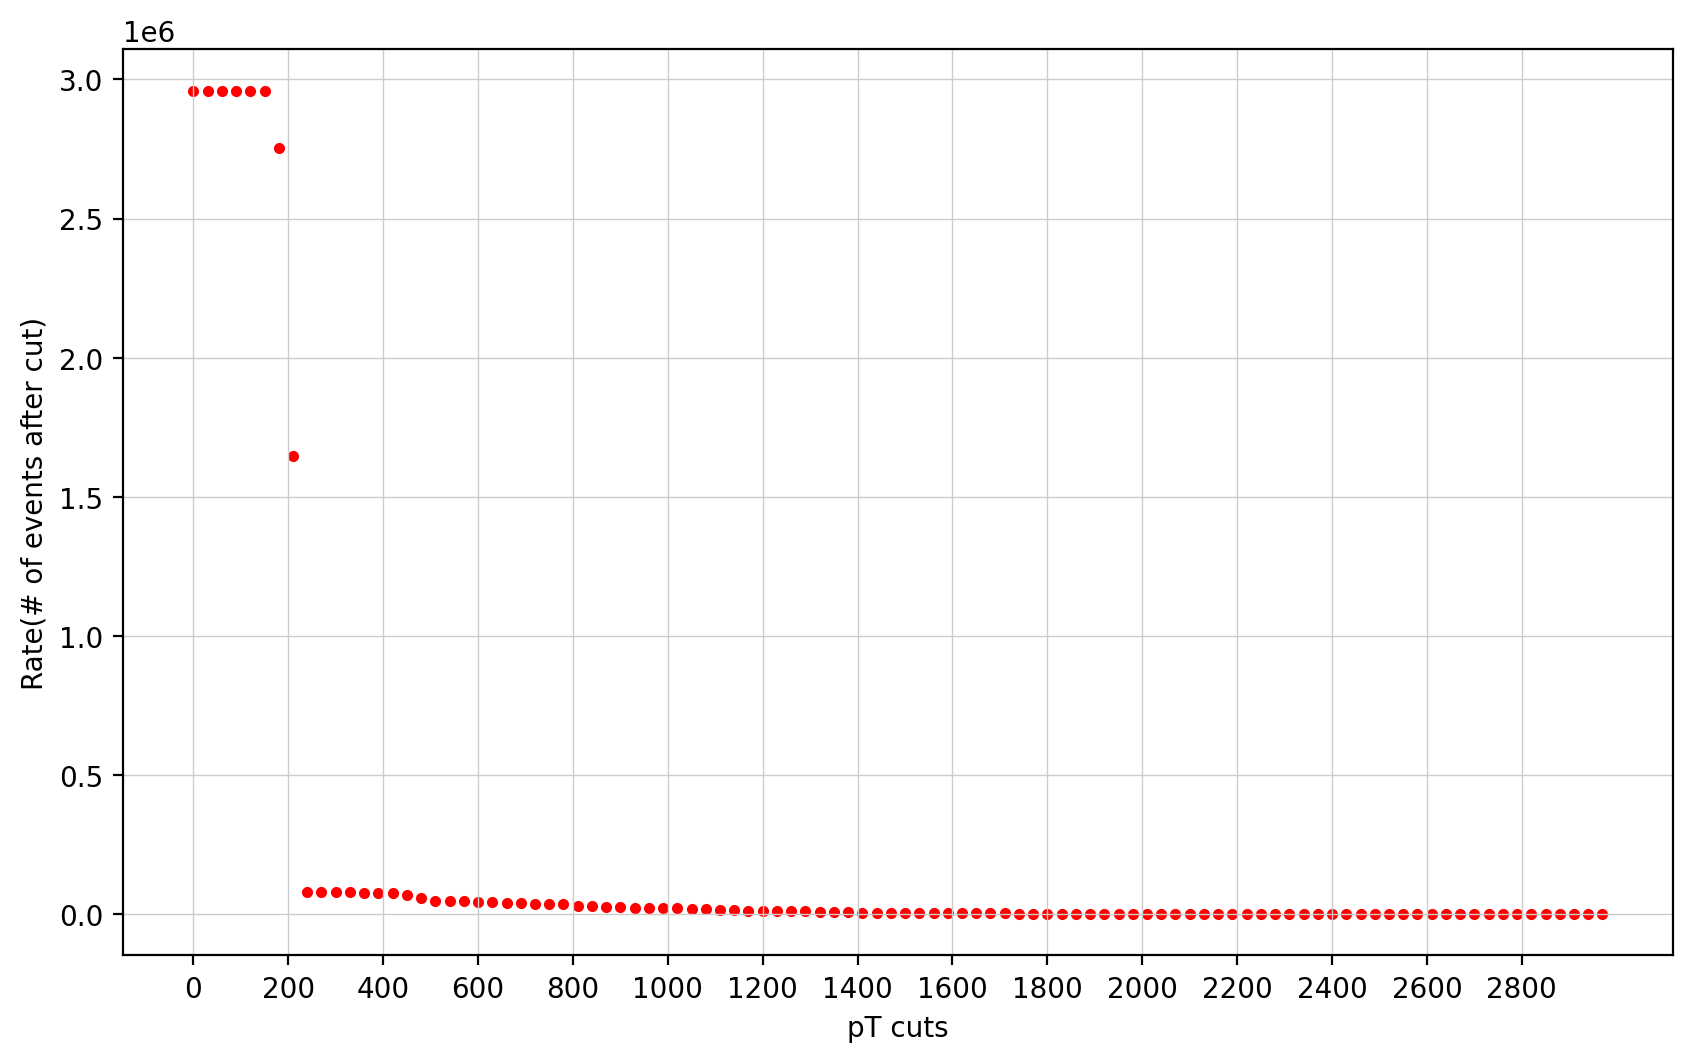

In [23]:
fig, ax = plt.subplots(1,1, figsize =(10, 6), dpi=200)
ax.scatter(hist_bins, all_ranges, marker='.', color='red', label='Scatter Plot')
# ax.set_yscale('log')
plt.xlabel("pT cuts")
plt.ylabel("Rate(# of events after cut)")
plt.xticks(range(0, 3000, 200))
plt.grid(True)
plt.show()


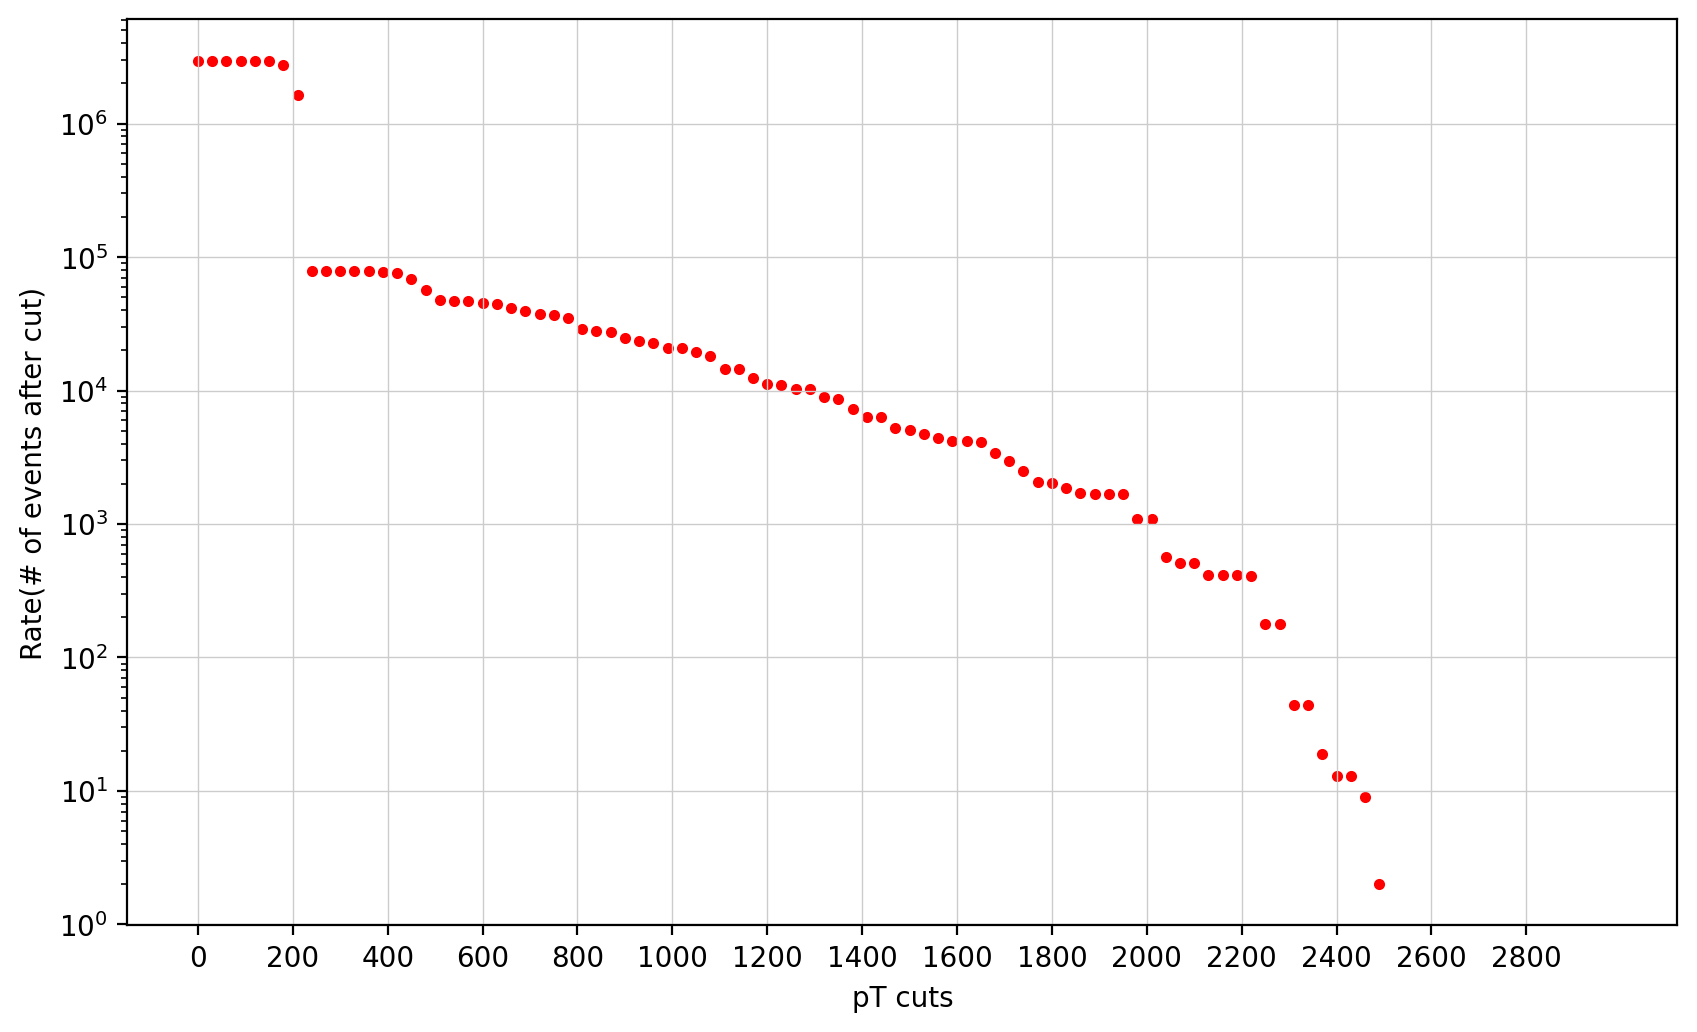

In [24]:
fig, ax = plt.subplots(1,1, figsize =(10, 6), dpi=200)
ax.scatter(hist_bins, all_ranges, marker='.', color='red', label='Scatter Plot')
ax.set_yscale('log')
plt.xlabel("pT cuts")
plt.ylabel("Rate(# of events after cut)")
plt.xticks(range(0, 3000, 200))
plt.grid(True)
plt.show()

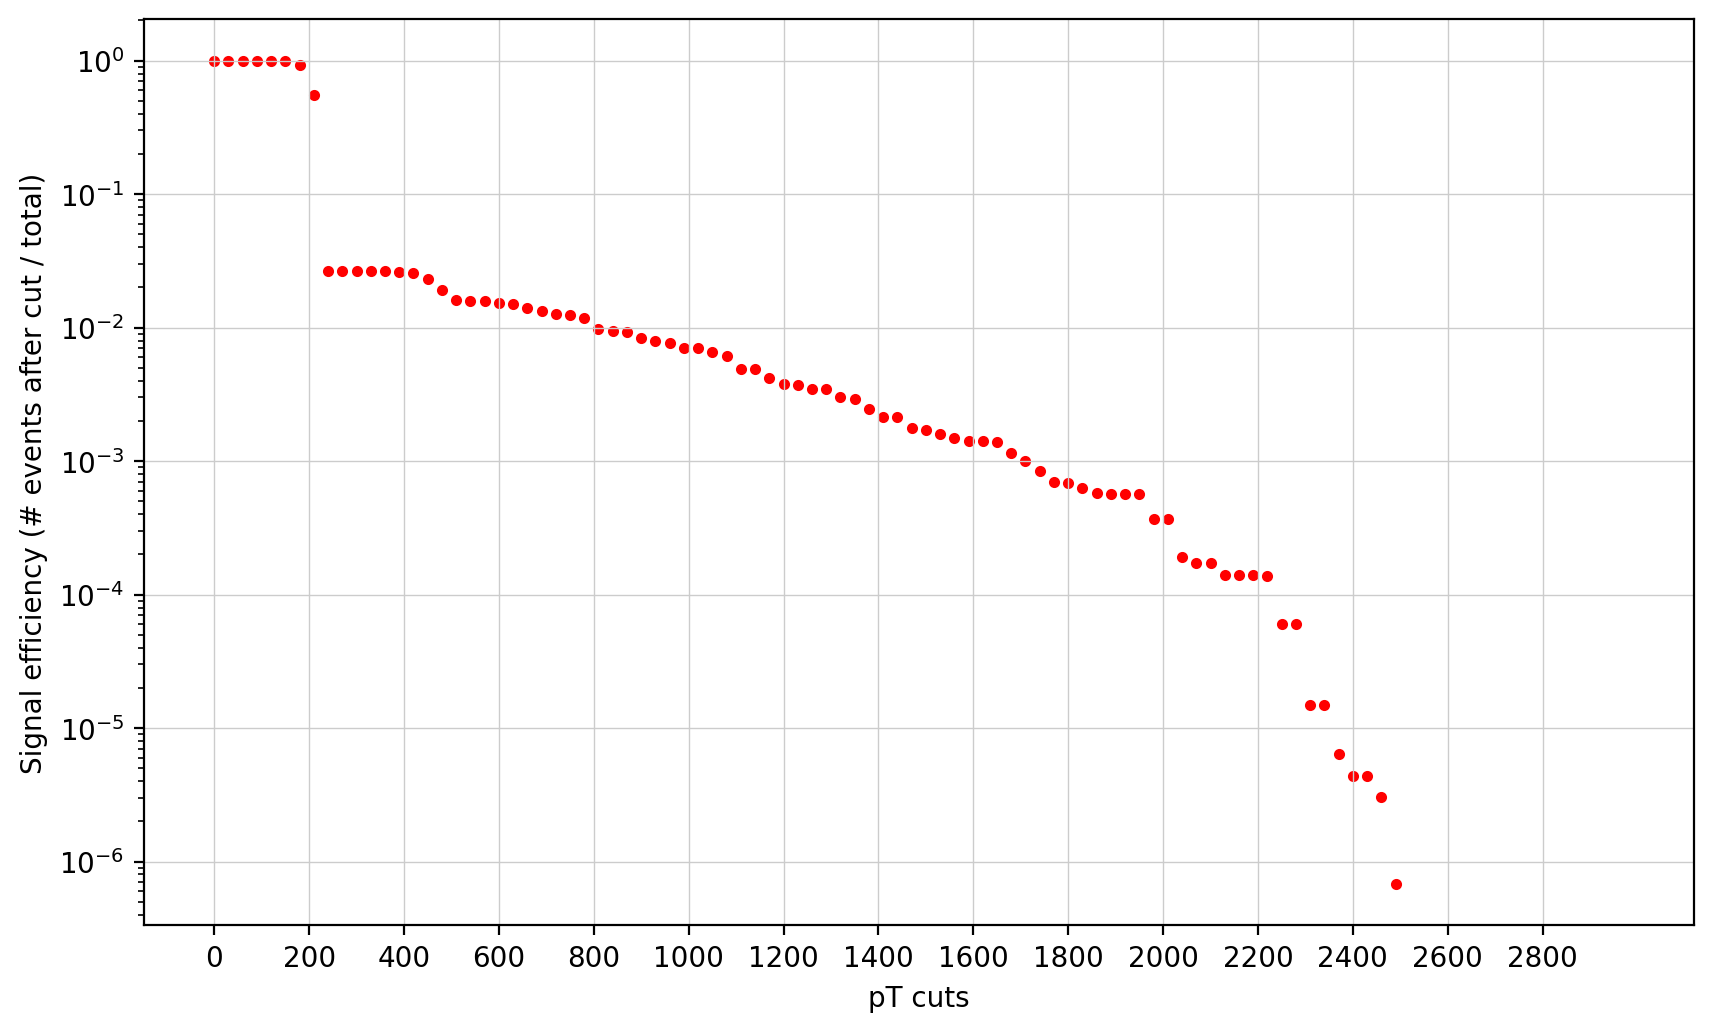

In [25]:
fig, ax = plt.subplots(1,1, figsize =(10, 6), dpi=200)
ax.scatter(hist_bins, range_cut, marker='.', color='red', label='Scatter Plot')
ax.set_yscale('log')
plt.xlabel("pT cuts")
plt.ylabel("Signal efficiency (# events after cut / total)")
plt.xticks(range(0, 3000, 200))
plt.grid(True)
plt.show()


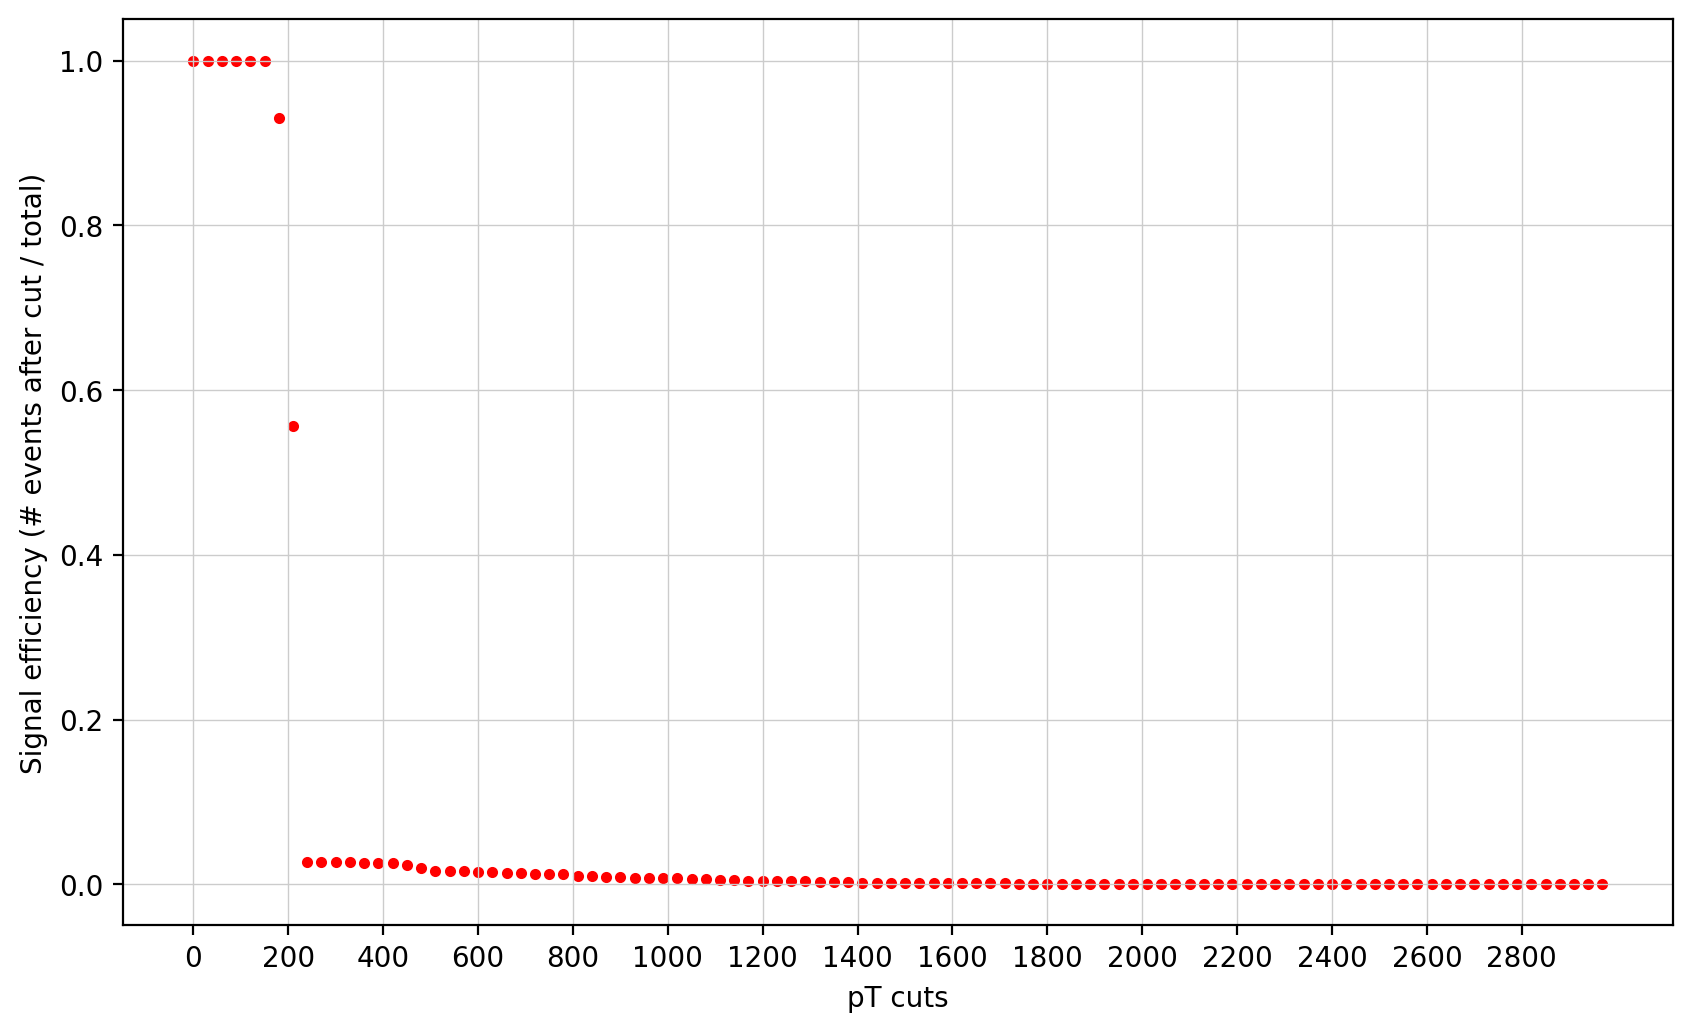

In [26]:
fig, ax = plt.subplots(1,1, figsize =(10, 6), dpi=200)
ax.scatter(hist_bins, range_cut, marker='.', color='red', label='Scatter Plot')
# ax.set_yscale('log')
plt.xlabel("pT cuts")
plt.ylabel("Signal efficiency (# events after cut / total)")
plt.xticks(range(0, 3000, 200))
plt.grid(True)
plt.show()


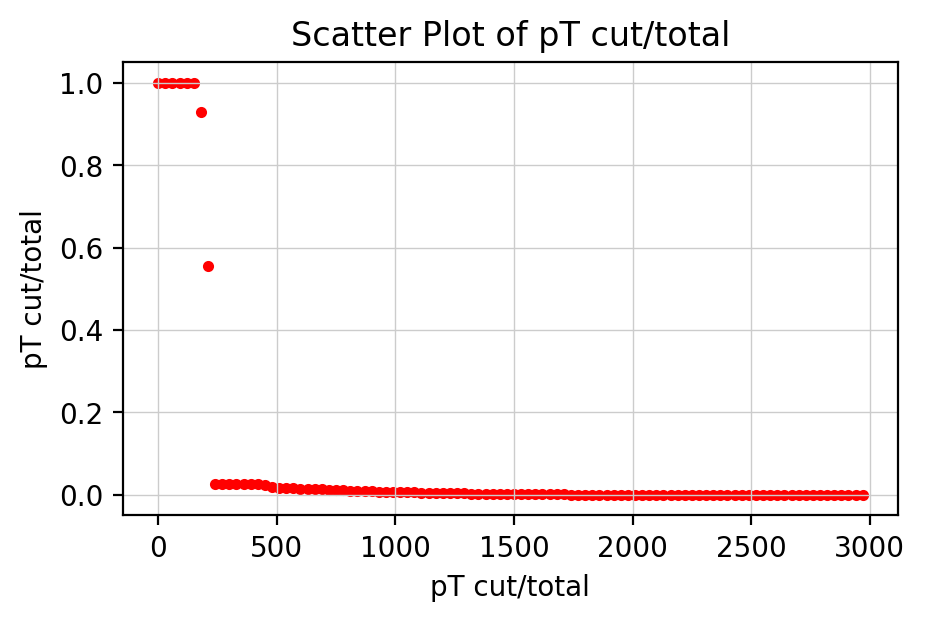

In [27]:
# Create a scatter plot of normalized values
plt.figure(figsize=(5, 3), dpi=200)
plt.scatter(hist_bins, range_cut, marker='.', color='red', label='Scatter Plot')

# Set labels, title, and grid for the plot
plt.xlabel('pT cut/total')
plt.ylabel('pT cut/total')
plt.title('Scatter Plot of pT cut/total')
plt.grid(True)

# Show the plot
plt.show()

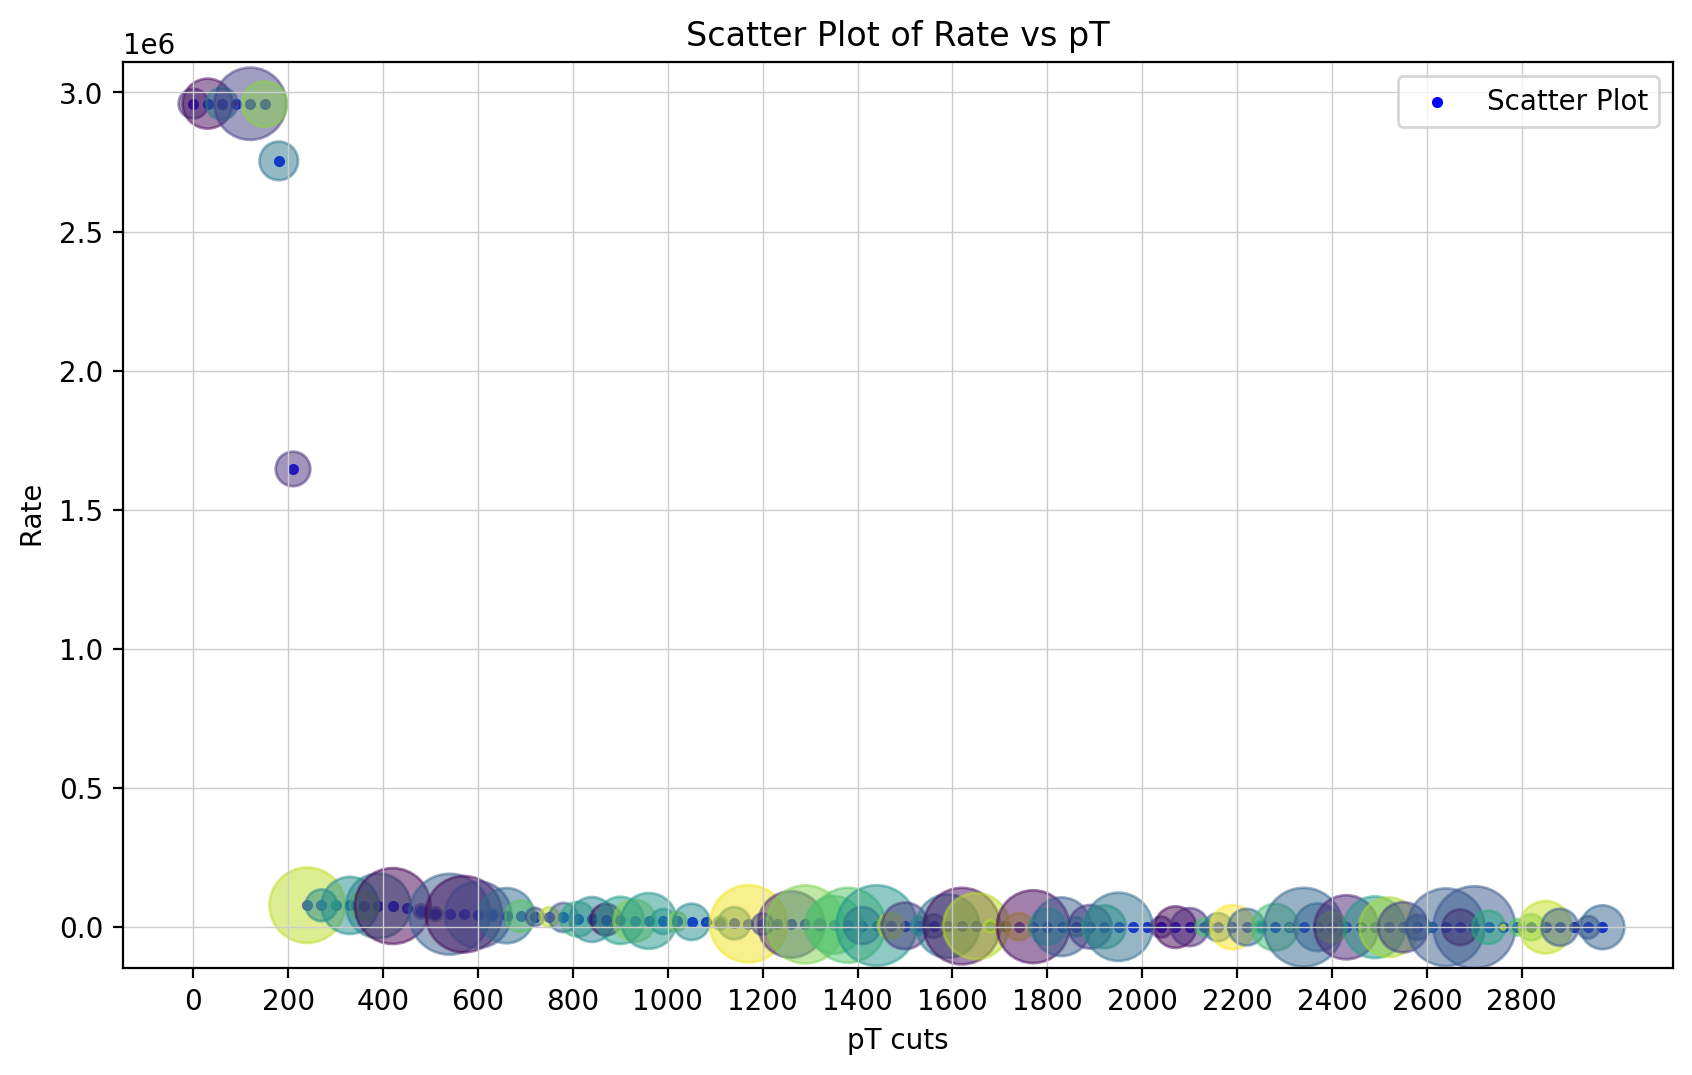

In [28]:
# Set the number of points (N) based on the length of range_cut
N = len(all_ranges)

# Randomly generate colors and sizes for the points
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # Adjust the size of points

# Create a scatter plot with random colors and sizes
fig, ax = plt.subplots(1,1, figsize =(10, 6), dpi=200)
ax.scatter(hist_bins, all_ranges, marker='.', color='blue', label='Scatter Plot')
ax.scatter(hist_bins, all_ranges, s=area, c=colors, alpha=0.5)

# ax.set_yscale('log')
# Set labels, title, legend, and grid for the plot
plt.title('Scatter Plot of Rate vs pT')
plt.xlabel("pT cuts")
plt.ylabel(" Rate ")
plt.xticks(range(0, 3000, 200))
plt.legend()
plt.grid(True)
plt.show()

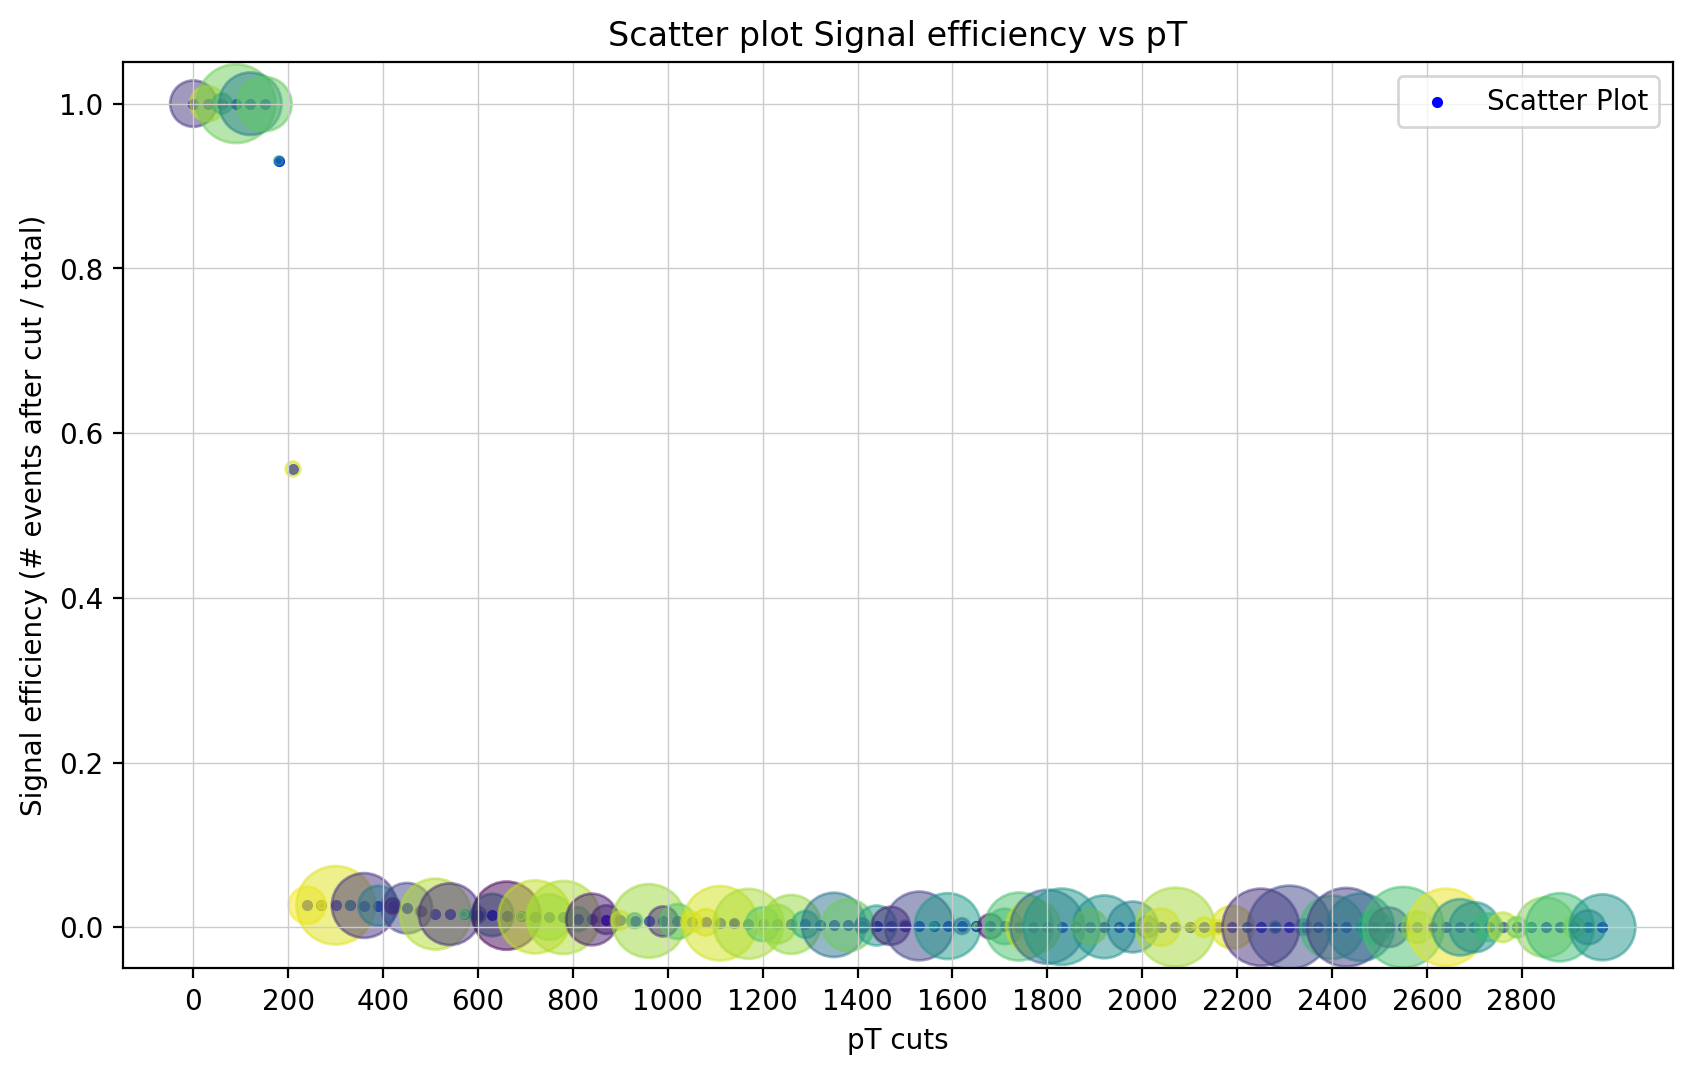

In [29]:
# Set the number of points (N) based on the length of range_cut
N = len(range_cut)

# Randomly generate colors and sizes for the points
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # Adjust the size of points

# Create a scatter plot with random colors and sizes
fig, ax = plt.subplots(1,1, figsize =(10, 6), dpi=200)
ax.scatter(hist_bins, range_cut, marker='.', color='blue', label='Scatter Plot')
ax.scatter(hist_bins, range_cut, s=area, c=colors, alpha=0.5)

# ax.set_yscale('log')
# Set labels, title, legend, and grid for the plot
plt.title('Scatter plot Signal efficiency vs pT')
plt.xlabel("pT cuts")
plt.ylabel("Signal efficiency (# events after cut / total)")
plt.xticks(range(0, 3000, 200))
plt.legend()
plt.grid(True)
plt.show()

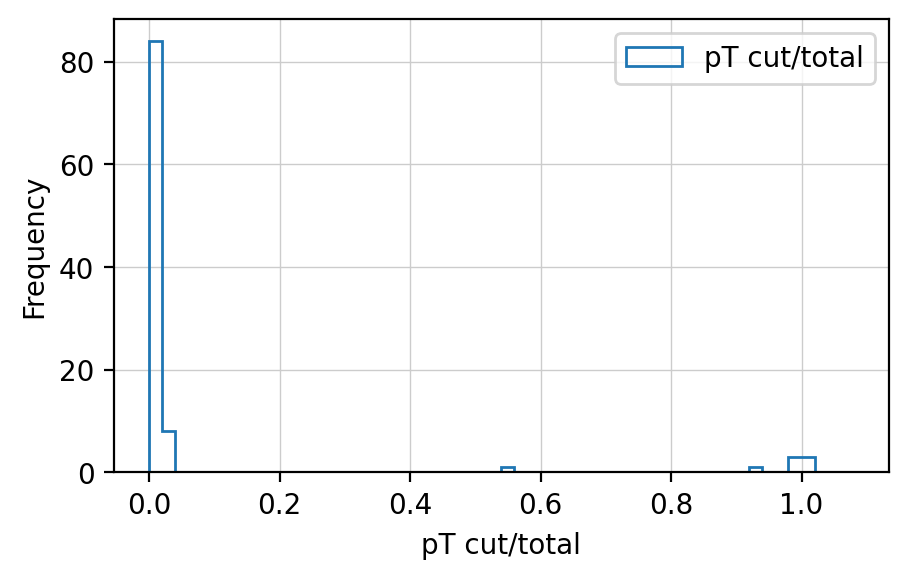

In [30]:
# Create a histogram of the normalized values
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
ax.hist(range_cut, label="pT cut/total", bins=np.arange(0, 1.1, 0.02), histtype='step')

# Set labels, legend, and grid for the plot
ax.set_xlabel('pT cut/total')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

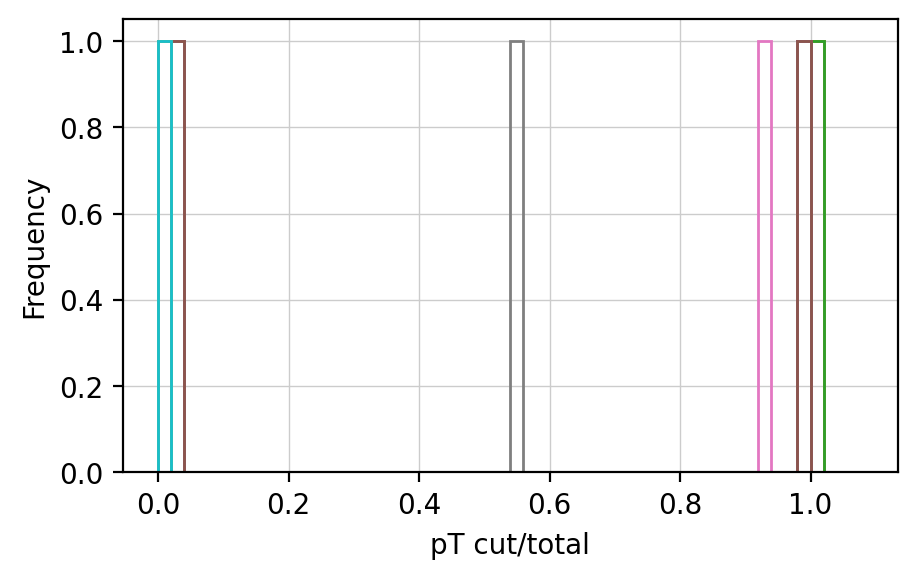

In [31]:
# Create a subplot with specified size and dpi
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)

# Iterate over the range_cut values and plot individual histograms
for i in range(len(range_cut)):
    ax.hist(range_cut[i], bins=np.arange(0, 1.1, 0.02), histtype='step')

# Set labels and grid for the plot
ax.set_xlabel('pT cut/total')
ax.set_ylabel('Frequency')
ax.grid(True)

# Show the plot
plt.show()

In [32]:
rates = [(x * 370000) for x in range_cut]

In [33]:
print((rates))

[370000.0, 370000.0, 370000.0, 369988.99935334036, 369950.7471047285, 369815.1141317091, 344272.1126174309, 205890.60302869155, 9886.331155953087, 9867.830068389156, 9858.704531955595, 9815.57699675589, 9774.82460117588, 9635.941437097992, 9547.936263820913, 8563.128373086796, 7129.16907953373, 5917.972880838265, 5869.595037005554, 5848.968824518739, 5675.458624932682, 5524.199733362704, 5213.931494621643, 4956.166342210657, 4651.773448844629, 4595.64514941081, 4390.6330980267085, 3598.961560578223, 3491.9552703435943, 3431.2016990187935, 3086.9314615115886, 2941.9229373618587, 2851.917646510302, 2620.4040372643526, 2612.4035669664368, 2424.5175223138117, 2254.1325064378784, 1806.8562138450031, 1797.1056406694177, 1561.0917668808909, 1388.7066334304786, 1384.8314056299257, 1276.4500345628426, 1274.4499169883636, 1115.6905845140896, 1079.1884387798473, 908.8034229039139, 790.1714492676258, 786.2962214670728, 655.9135570807202, 628.0369183864186, 591.4097653037712, 554.282582827504, 521.

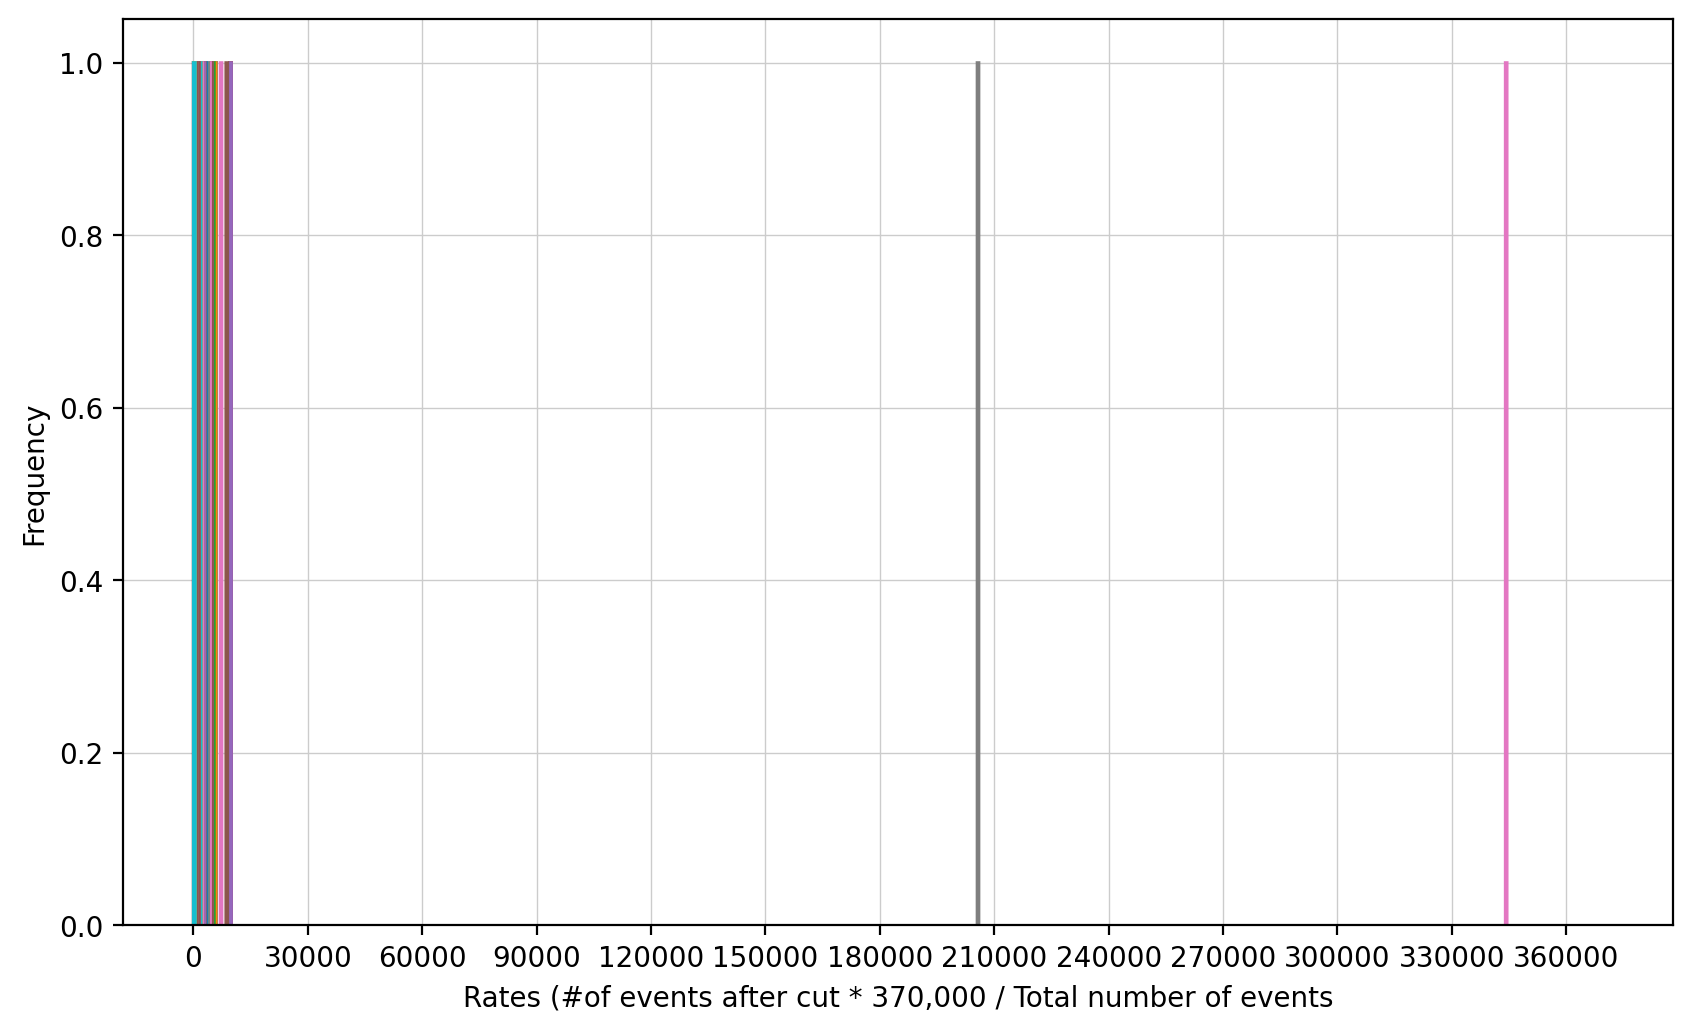

In [34]:
# Create a subplot with specified size and dpi
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# Iterate over the range_cut values and plot individual histograms
for i in range(len(rates)):
    ax.hist(rates[i], bins=np.arange(0,370000, 500), histtype='step')

# Set labels and grid for the plot
ax.set_xlabel('Rates (#of events after cut * 370,000 / Total number of events')
ax.set_ylabel('Frequency')
ax.grid(True)
plt.xticks(range(0, 370000, 30000))
# Show the plot
plt.show()

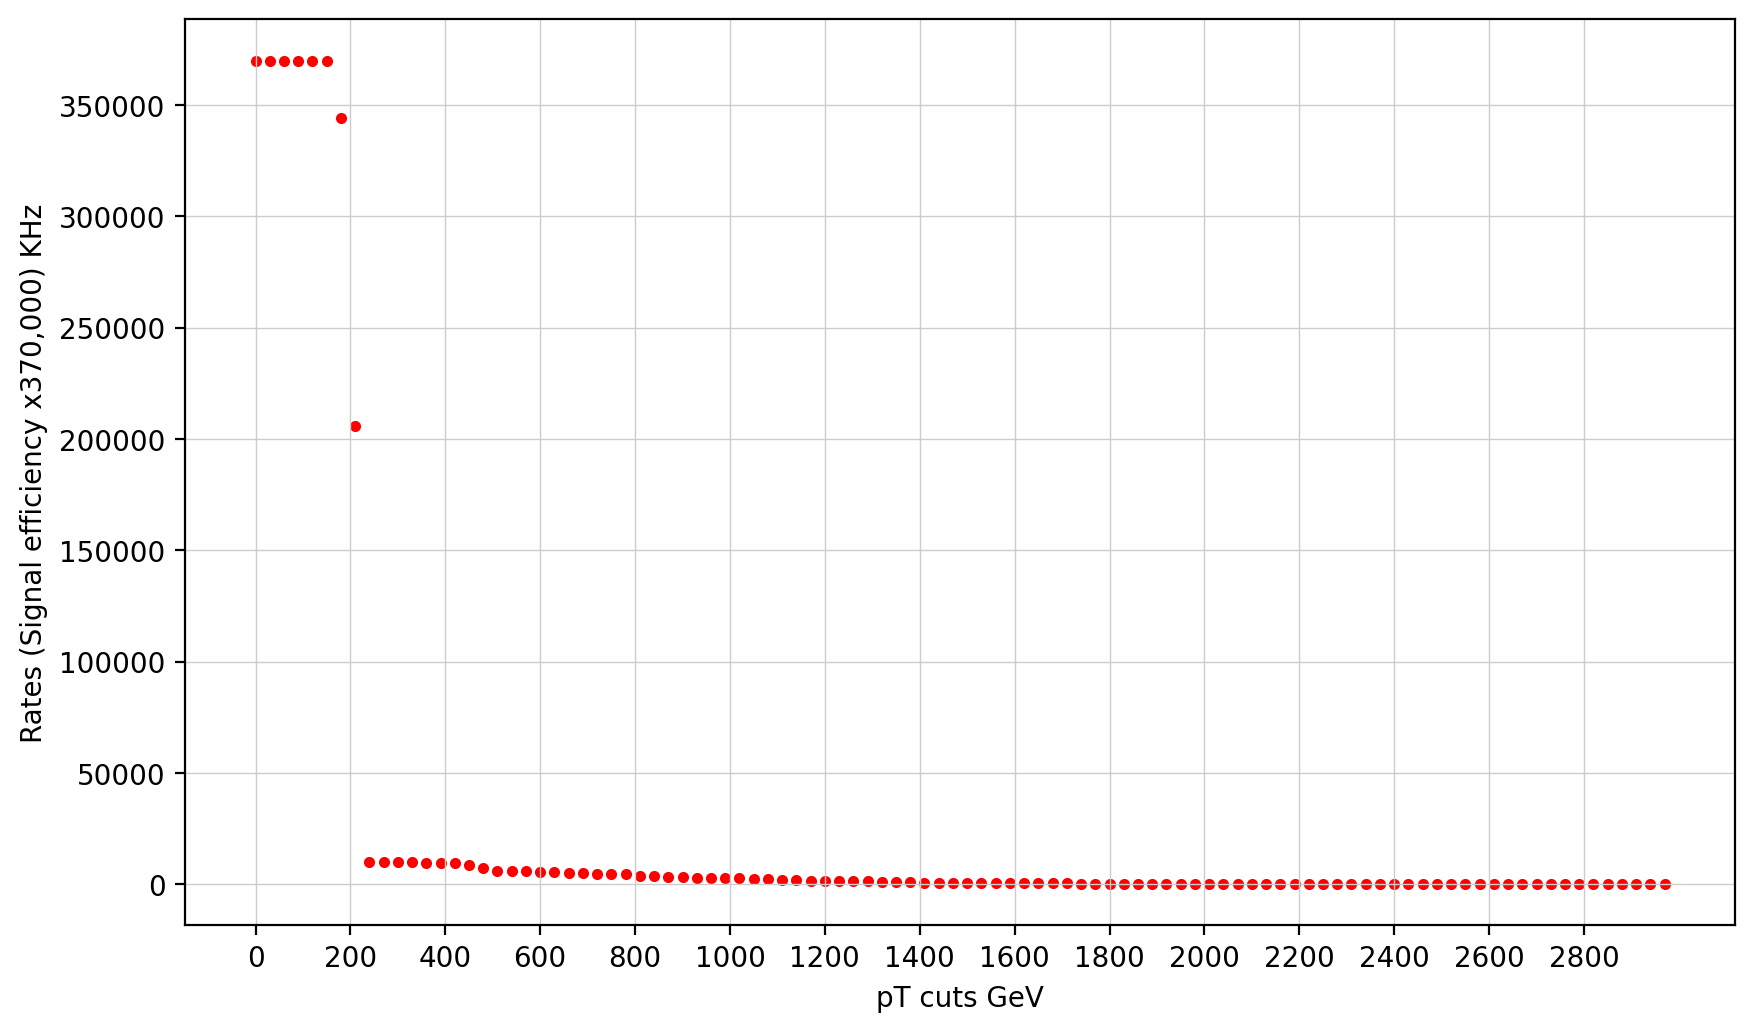

In [35]:
fig, ax = plt.subplots(1,1, figsize =(10, 6), dpi=200)
ax.scatter(hist_bins, rates, marker='.', color='red', label='Scatter Plot')
# ax.set_yscale('log')
plt.xlabel("pT cuts GeV")
plt.ylabel("Rates (Signal efficiency x370,000) KHz")
plt.xticks(range(0, 3000, 200))
plt.grid(True)
plt.show()
